In [1]:
!pip3 install JSAnimation

In [2]:
import numpy
import pandas
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from JSAnimation import IPython_display
from matplotlib import animation
from IPython.display import HTML

# Implementation of k-means

In [3]:
def generateCircles(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    circles, labels = datasets.make_circles(n_samples=n, factor=.5, noise=epsilon)
    scaler.fit(circles)
    return "nc", scaler.transform(circles), labels, 2
def generateMoons(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    moons, labels = datasets.make_moons(n_samples=n, noise=epsilon)
    scaler.fit(moons)
    return "nm", scaler.transform(moons), labels, 2
def generateBlobs(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    blobs, labels = datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 0.5, epsilon + 1.25, epsilon + 0.25])
    scaler.fit(blobs)
    return "nb", scaler.transform(blobs), labels, 3
def generateRandom(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    no_structure, labels = np.random.rand(n, 2), np.zeros(n)
    scaler.fit(no_structure)
    return "ns", scaler.transform(no_structure), labels, 1

In [12]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)
def getY(labels):
    Y = np.zeros((len(labels), max(labels)+1))
    for i in range(0, len(labels)):
        Y[i, labels[i]] = 1
    return Y

In [5]:
n=500
r =3
dataID, D, labels, r_true = generateBlobs(0.1,n)

Implementation of $k$-means algorithm as alternating minimization (block coordinate descent).

In [21]:
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum(D**2,1).reshape(-1,1)  - 2* D@X + np.sum(X**2,0)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.001, t_max=10000, verbose = False):
    rss_old = np.inf
    X = X_init
    Y = update_assignment(D,X)
    t=0
    if verbose:
        print(X,Y)
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        if verbose:
            print(X,Y)
        t+=1
    return X,Y

Visualization of $k$-means alternating update steps.

In [7]:
def animate(i):
    global X,D,Y
    ax.cla()
    if i==0: #initialize
        ax.scatter(D[:, 0], D[:, 1], s=10)
        ax.scatter(X.T[:, 0], X.T[:, 1], c='red', s=50, marker = 'D')  
    elif i%2==1: # update cluster assignments
        dist = np.sum(D**2,1).reshape(-1,1)  - 2* D@X + np.sum(X**2,0)
        closest_centroid = np.argmin(dist,1)
        Y = getY(closest_centroid)
        ax.scatter(D[:, 0], D[:, 1], c=closest_centroid, s=10)
        ax.scatter(X.T[:, 0], X.T[:, 1], c='red', s=50, marker = 'D')
    else: # update centroids
        _,closest_centroid = np.nonzero(Y)
        ax.scatter(D[:, 0], D[:, 1], c=closest_centroid, s=10)
        X = update_centroid(D,Y)
        ax.scatter(X.T[:, 0], X.T[:, 1], c='red', s=50, marker = 'D')
    return

Initialization is important for $k$-means. If we have a suitable initialization, then the resulting clustering is good.

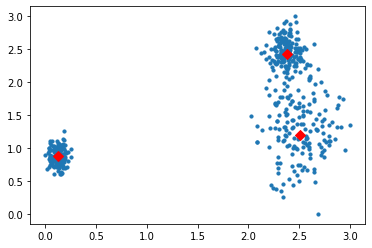

In [8]:
fig = plt.figure()
ax = plt.axes()
X = np.array([[1,1,0.5],[0,2,1.5]])# inital centroids
Y=0
anim = animation.FuncAnimation(fig, animate, frames=20, interval=200, blit=False)
HTML(anim.to_jshtml())

If we use random initialization, then the clustering might be really bad.

In [9]:
d,r=2,3
X =np.random.rand(d,r)*3
Y=0
anim=animation.FuncAnimation(fig, animate, frames=20, interval=200, blit=False)
HTML(anim.to_jshtml())

Another problem is the determination of a suitable number of clusters. If we use two-dimensional data, then we can easily see how many clusters there are. However, in higher dimensions this is not easy to determine.  

In [10]:
d,r=2,4
X =np.random.rand(d,r)*3
Y=0
anim = animation.FuncAnimation(fig, animate, frames=20, interval=200, blit=False)
HTML(anim.to_jshtml())

# Movie Decomposition Example

In [10]:
M = np.array([[5,3,1,1],[2,1,5,3],[2,1,5,3],[4,3,4,2],[5,5,3,1],[3,1,5,3]])

In [12]:
r=2
kmeans = KMeans(n_clusters=r)
kmeans.fit(M)
    
# Create indicator matrix and centroid matrix
Y=getY(kmeans.labels_)
X = kmeans.cluster_centers_.T

The cluster indicator matrix has exactly one one in every row. Every column represents one cluster.

In [13]:
Y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

The matrix $Y^\top Y$ is a diagonal matrix, having the number of points which are assigned to each cluster on the diagonal.

In [14]:
Y.T@Y

array([[3., 0.],
       [0., 3.]])

In [15]:
X

array([[4.66666667, 2.33333333],
       [3.66666667, 1.        ],
       [2.66666667, 5.        ],
       [1.33333333, 3.        ]])

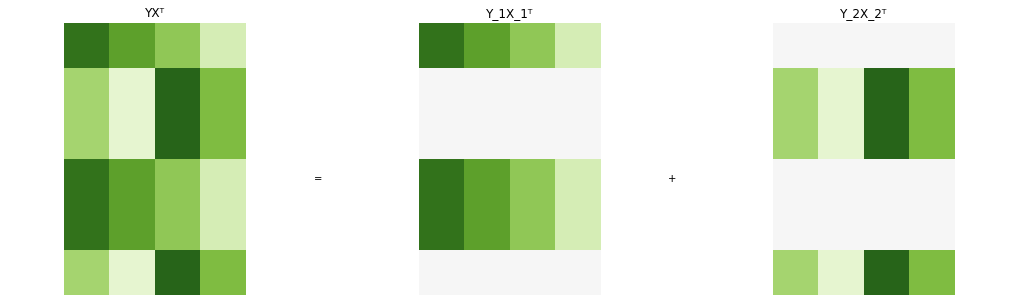

In [16]:
plt.figure(2, figsize=(18, 5))
#--------------
plt.subplot(1,3,1)
plt.set_cmap('PiYG')
plt.imshow(Y@X.T,vmin = -5, vmax = 5)
plt.title("YXᵀ")
plt.axis('equal')
plt.axis('off')
plt.text(5,3, '=')

plt.subplot(1,3,2)
plt.imshow(np.outer(Y[:,0],X[:,0]),vmin = -5, vmax = 5)
plt.title("Y_1X_1ᵀ")
plt.axis('equal')
plt.axis('off')
plt.text(5,3, '+')

plt.subplot(1,3,3)
plt.imshow(np.outer(Y[:,1],X[:,1]),vmin = -5, vmax = 5)
plt.title("Y_2X_2ᵀ")
plt.axis('equal')
plt.axis('off')
plt.show()

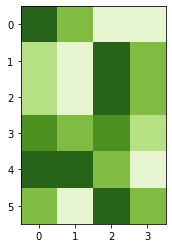

In [17]:
plt.imshow(M,vmin = -5, vmax = 5)